# Jonction PN

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.
It also includes setting up the formatting parameters for the plots and visualizations.

## Import

In [1]:
# ============================================================
# Import Required Libraries
# ============================================================

# ------------------------------------------------------------
# Numerical and Plotting Libraries
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Devsim
# ------------------------------------------------------------
from devsim import print_node_values, set_parameter, solve, write_devices
import devsim.python_packages.simple_physics as simple_physics
import diode_common
from devsim import (
    get_node_model_values,
    get_edge_model_values,
    get_element_model_values,
    edge_average_model,
    edge_model,
    get_region_list,
    get_contact_list,
    get_element_model_values,
    get_node_model_list,
    get_edge_model_list,
)
import devsim

# ============================================================
# End of Imports
# ============================================================

## Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Objective

The goal of this first notebook is to model a **PN junction**, the fundamental building block of many semiconductor devices.

We aim to simulate the behavior of semiconductor materials, which are essential in electronics: they form the basis of **diodes**, **transistors**, and therefore of computers and most modern electronic circuits.

Semiconductors used in industry are typically **doped**, meaning that small amounts of impurities are added to modify their electrical properties. There are two main types of doping:

* **N-type doping**: donor atoms are introduced, providing additional electrons and increasing the density of free (negatively charged) electrons.
* **P-type doping**: acceptor atoms are introduced, creating a deficit of electrons. This results in an excess of holes, which act as positively charged carriers.

This notebook focuses specifically on building and analyzing the junction formed by combining these two doped regions: the **PN junction**.

## 1D diode simulation

### Device and Region Definition

The goal of this section is to define the physical model of the device—in our case, a diode composed of a positively doped region and a negatively doped region.
Before using numerical solvers such as **Poisson** or **drift–diffusion**, we must prepare several essential elements.
These three components are:

* **Geometry and mesh** – the spatial structure of the device and its discretization.
* **Material parameters** – the physical properties associated with each region.
* **Doping profile** – the distribution of acceptor and donor impurities within the semiconductor.

In [3]:
# ============================================================
# Device and Region Definition
# ============================================================
device = "diode1"
region = "bulk"

**Role —** The purpose is to assign a symbolic name to each object so that we can easily reference it later. This becomes especially useful when reusing simulations or modifying specific components, since clear names allow us to retrieve and manipulate simulation parameters efficiently.

```{note}
Choose clear and meaningful names, just as you would when writing code.  
For now, this notebook handles only a single device, but as soon as multiple components are involved, poor naming quickly becomes confusing  
(*e.g., device='diode1', region='bulk'*).
```

In [4]:
# ------------------------------------------------------------
# Mesh and Material Parameters
# ------------------------------------------------------------
diode_common.CreateMesh(device=device, region=region)

mid
bot
 (region: bulk)
 (contact: top)
 (contact: bot)


At the output of the function, we obtain the following:

```text
mid
bot
 (region: bulk)
 (contact: top)
 (contact: bot)
```

This indicates that the code has created two geometric regions, named **`mid`** and **`bot`**, along with two contacts named **`top`** and **`bot`**.
The next step is to understand how this structure is produced by examining the `CreateMesh` function.

Here is the `CreateMesh` code:

```python
def CreateMesh(device, region):
    """
    Meshing
    """
    create_1d_mesh(mesh="dio")
    
    add_1d_mesh_line(mesh="dio", pos=0, ps=1e-7, tag="top")
    add_1d_mesh_line(mesh="dio", pos=0.5e-5, ps=1e-9, tag="mid")
    add_1d_mesh_line(mesh="dio", pos=1e-5, ps=1e-7, tag="bot")
    
    add_1d_contact(mesh="dio", name="top", tag="top", material="metal")
    add_1d_contact(mesh="dio", name="bot", tag="bot", material="metal")
    
    add_1d_region(mesh="dio", material="Si", region=region, tag1="top", tag2="bot")
    
    finalize_mesh(mesh="dio")
    create_device(mesh="dio", device=device)
```

The first line:

```python
create_1d_mesh(mesh="dio")
```

initializes the mesh.
According to the documentation:

> *Create a mesh to create a 1D device*
> *mesh (str) – name of the 1D mesh being created*

Therefore, **`dio`** is simply the name of the mesh, chosen here to mean "diode".

Then we have:

```python
add_1d_mesh_line(mesh="dio", pos=0, ps=1e-7, tag="top")
add_1d_mesh_line(mesh="dio", pos=5e-6, ps=1e-9, tag="mid")
add_1d_mesh_line(mesh="dio", pos=1e-5, ps=1e-7, tag="bot")
```

The documentation states:

> *Add a mesh line to a 1D mesh*
> **pos**: physical position of the mesh point
> **ps**: mesh spacing toward the positive direction
> **tag**: label for the position

These lines define the segments of the 1D mesh by specifying points and the mesh spacing between them:

* **First zone**: between **0 µm and 5 µm**, with a very fine spacing of **1 nm**.
* **Second zone**: between **5 µm and 10 µm**, with a coarser spacing of **100 nm**.

This creates two regions with different mesh densities, ensuring finer resolution where the physical quantities vary rapidly (typically near the PN junction).

Next, the goal is to add contact regions. To do this, we use the following commands:

```python
add_1d_contact(mesh="dio", name="top", tag="top", material="metal")
add_1d_contact(mesh="dio", name="bot", tag="bot", material="metal")
```

According to the documentation:

> **Add a contact to a 1D mesh**
> Parameters:
>   **material (str)** – material of the contact being created
>   **mesh (str)** – mesh to which the contact is added
>   **name (str)** – name assigned to the contact
>   **tag (str)** – label indicating the position where the contact is placed

These lines create two contacts. Both contacts use the material `"metal"`, meaning they are conductive terminals. As before, everything is added to the same mesh—`dio`.
Each contact is assigned a name and a tag.
The **tag** determines where the contact is positioned: one at the `top` marker and the other at the `bot` marker.

Finally, we need to assign a material region between these two boundaries. This is done with:

```python
add_1d_region(mesh="dio", material="Si", region=region, tag1="top", tag2="bot")
```

Documentation excerpt:

> **Add a region to a 1D mesh**
> Parameters:
>   **mesh (str)** – mesh to which the region is added
>   **tag1 (str)** – label marking one boundary of the region
>   **tag2 (str)** – label marking the other boundary
>   **region (str)** – name of the region
>   **material (str)** – material assigned to the region

This means that between the tags `top` and `bot`, the entire region will be filled with **silicon (`Si`)**.

The last two lines of the function simply finalize the mesh and create the device model; they do not introduce new physical elements.

In summary, the mesh now contains:

* the three mesh lines defined earlier,
* two metal contacts (`top` and `bot`),
* and a silicon region spanning between these two boundaries.

```{figure} ./images/DIode_1D_mesh.svg
:name: Diode_1D_mesh_introduction_simulation
:align: center
:width: 500px

1D representation of a diode used for simulation.
```

The next cell provides an overview of all the elements that have been created.

In [5]:
# === RÉGIONS ===
print("=== Régions du device ===")
print(get_region_list(device=device))

# === CONTACTS ===
print("\n=== Contacts ===")
print(get_contact_list(device=device))

# === NOEUDS (positions) ===
x = get_node_model_values(device=device, region=region, name="x")
print("\n=== Positions des nœuds ===")
for i, xx in zip(range(5), x):
    print(f"Node {i} : x = {xx}")

=== Régions du device ===
('bulk',)

=== Contacts ===
('bot', 'top')

=== Positions des nœuds ===
Node 0 : x = 0.0
Node 1 : x = 1e-07
Node 2 : x = 1.9801960392078414e-07
Node 3 : x = 2.940980314486582e-07
Node 4 : x = 3.8827372556479795e-07


### Definition of Physical Parameters

The goal of this section is to define the material properties and the environmental conditions required for the simulation.

In **DEVSIM**, a material (in our case, silicon, *Si*) requires a large number of physical parameters to properly describe its behavior:

**Structural parameters**

* Silicon permittivity
* Bandgap energy $E_g$
* Electron affinity $\chi$

**Electrical parameters**

* Effective density of states in the conduction band ($N_c$)
* Effective density of states in the valence band ($N_v$)
* Intrinsic carrier concentration ($n_i$)
* Electron mobility $\mu_n$, hole mobility $\mu_p$
* Effective masses

**Temperature-dependent parameters**

* $E_g(T)$
* $n_i(T)$
* Mobilities $\mu(T)$, if modeled

**Recombination parameters**

* Carrier lifetimes $\tau_n$ and $\tau_p$ (later adjusted using `set_parameter`)
* SRH recombination parameters
* Auger recombination parameters

**Other parameters**

* Coefficients related to the electric field, such as saturation velocity
* Mobility degradation parameters (Caughey–Thomas model)

To begin, the code first sets the **temperature** of the system, as many of the above parameters depend on it.

#### System temperature

In [6]:
diode_common.SetParameters(device=device, region=region)

The corresponding code is:

```python
def SetParameters(device, region):
    """
    Set parameters for 300 K
    """
    SetSiliconParameters(device, region, 300)
```

This function configures all silicon-related physical parameters at a temperature of **300 K**, which corresponds approximately to **27 °C**. It initializes the material properties that depend on temperature—such as bandgap energy, intrinsic carrier concentration, and mobilities—so that the simulation reflects realistic physical conditions.

#### Si parameter 

In [7]:
# Carrier lifetimes
set_parameter(device=device, region=region, name="taun", value=1e-8)
set_parameter(device=device, region=region, name="taup", value=1e-8)

These values correspond to the **minority carrier lifetimes** in a semiconductor:

* **$\tau_n$ (taun)**: lifetime of electrons when they are minority carriers
* **$\tau_p$ (taup)**: lifetime of holes when they are minority carriers

To give a sense of typical magnitudes, the following table summarizes the expected values:

| Material                 | Typical $\tau_n$, $\tau_p$ |
| ------------------------ | -------------------------- |
| High-quality pure Si     | $10^{-5}$ to $10^{-3}$ s   |
| Moderately doped Si      | $10^{-6}$ to $10^{-8}$ s   |
| Heavily doped Si         | $10^{-9}$ to $10^{-11}$ s  |
| Degraded / irradiated Si | $10^{-12}$ to $10^{-14}$ s |

The carrier lifetime is the **relaxation time constant** describing how quickly the excess carrier concentration returns to equilibrium after a brief external excitation.
The speed of recombination of excess electron-hole pairs depends strongly on the density of **recombination centers** in the bandgap, which originate from **impurities**, **crystal defects**, or **radiation-induced damage**.

In [8]:
# Doping
diode_common.SetNetDoping(device=device, region=region)

This time, the goal is to modify the silicon parameters so that one region is doped **acceptor-type (P-type)** and the other is doped **donor-type (N-type)**.

The corresponding code is:

```python
CreateNodeModel(device, region, "Acceptors", "1.0e18*step(0.5e-5-x)")
CreateNodeModel(device, region, "Donors", "1.0e18*step(x-0.5e-5)")
CreateNodeModel(device, region, "NetDoping", "Donors-Acceptors")
```

The purpose here is to create **node models**, although the role of these models may not yet be entirely clear. In DEVSIM, a *node model* defines a spatially dependent quantity on each mesh node. These models are later used by the Poisson and drift–diffusion solvers to compute charge, electric field, and carrier transport.

At the end, the doping profile is defined by the following equation:

$$
\text{NetDoping}(x) =
\begin{cases}
-1\times 10^{18} & x < 0.5\times 10^{-5} \quad \text{(P-type region)} \\
+1\times 10^{18} & x > 0.5\times 10^{-5} \quad \text{(N-type region)}
\end{cases}
$$

This creates a classic **PN junction**: acceptor concentration on the left, donor concentration on the right.

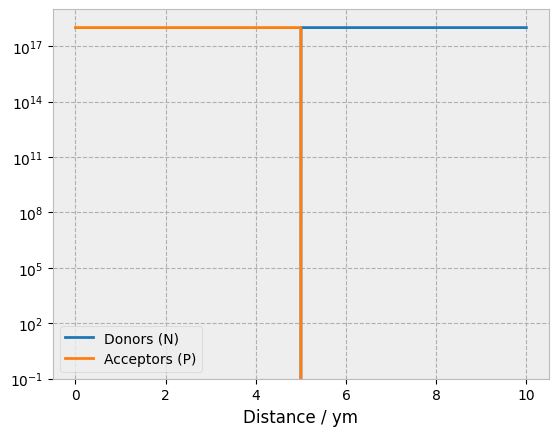

In [9]:
x = get_node_model_values(device=device, region=region, name="x")
Na = get_node_model_values(device=device, region=region, name="Acceptors")
Nd = get_node_model_values(device=device, region=region, name="Donors")

plt.figure()
plt.plot(np.array(x)*1e6, Nd, label="Donors (N)")
plt.plot(np.array(x)*1e6, Na, label="Acceptors (P)")
plt.legend()
plt.yscale("log")
plt.ylim(1e-1, 1e19)
plt.xlabel("Distance / ym")
plt.show()

So we can clearly see the two areas, with the donor area and the acceptor area.

In [10]:
# ------------------------------------------------------------
# Initial Guess for Potential, Electron/Hole Densities
# ------------------------------------------------------------
diode_common.InitialSolution(device, region);

The code performs the following operations:

```python
# Create Potential, Potential@n0, Potential@n1
CreateSolution(device, region, "Potential")

# Create potential-only physical models
CreateSiliconPotentialOnly(device, region)

# Set up the contacts applying a bias
for i in get_contact_list(device=device):
    if circuit_contacts and i in circuit_contacts:
        CreateSiliconPotentialOnlyContact(device, region, i, True)
    else:
        set_parameter(device=device, name=GetContactBiasName(i), value=0.0)
        CreateSiliconPotentialOnlyContact(device, region, i)
```

First, we have:

```python
CreateSolution(device, region, "Potential")
```

This command creates the **solution variable** `Potential`, which will later be solved by the numerical solvers. In DEVSIM, every physical quantity to be computed (potential, electron density, hole density, etc.) must be explicitly declared as a *solution*.

Next:

```python
CreateSiliconPotentialOnly(device, region)
```

This line generates all the **physical models** required for a potential-only simulation.
It sets up the necessary Poisson equation for the silicon region, namely:

$$
\nabla \cdot (\varepsilon \nabla \psi)
= -q,(N_D - N_A + p - n)
$$

This corresponds to solving only the electrostatic potential, without carrier continuity equations (i.e., drift–diffusion is not included yet).

Then we handle the contacts:

```python
for i in get_contact_list(device=device):
    if circuit_contacts and i in circuit_contacts:
        CreateSiliconPotentialOnlyContact(device, region, i, True)
    else:
        set_parameter(device=device, name=GetContactBiasName(i), value=0.0)
        CreateSiliconPotentialOnlyContact(device, region, i)
```

The function `get_contact_list` returns all defined contacts, which in this device are:

* `top`
* `bot`

### Contacts linked to an external circuit

```python
if circuit_contacts and i in circuit_contacts:
    CreateSiliconPotentialOnlyContact(device, region, i, True)
```

If the contact is connected to a circuit (SPICE interface), DEVSIM creates a contact model that interacts with external components such as:

* resistors
* voltage sources
* current sources
* transistors
* any SPICE-defined boundary condition

This is not used in this simple simulation, but DEVSIM fully supports mixed TCAD-SPICE operation.

### Contacts with no external circuit

```python
set_parameter(device=device, name=GetContactBiasName(i), value=0.0)
CreateSiliconPotentialOnlyContact(device, region, i)
```

If the contact is **not** connected to an external circuit, then:

1. A default bias is assigned (`0.0` V in this case).
2. A physical contact model is created for that boundary.

This defines the electrostatic boundary conditions for the Poisson solver.

```{danger}
Note: this part of the code is not entirely clean and should be improved in the near future.  
Some internal mechanisms are not yet fully clear, and the current implementation mixes contact definition and circuit handling logic.
```

#### Initializing drift diffusion

In [11]:
# ============================================================
# Drift–Diffusion Initial Conditions (Construct Jn, Jp Models)
# ============================================================
diode_common.DriftDiffusionInitialSolution(device, region)

Region: bulk, Equation: PotentialEquation, Variable: Potential


The goal of this section is to understand the meaning of the following code:

```python
####
#### drift diffusion solution variables
####
CreateSolution(device, region, "Electrons")
CreateSolution(device, region, "Holes")

####
#### create initial guess from dc only solution
####
set_node_values(
    device=device, region=region, name="Electrons", init_from="IntrinsicElectrons"
)
set_node_values(
    device=device, region=region, name="Holes", init_from="IntrinsicHoles"
)

###
### Set up equations
###
CreateSiliconDriftDiffusion(device, region)
for i in get_contact_list(device=device):
    if circuit_contacts and i in circuit_contacts:
        CreateSiliconDriftDiffusionAtContact(device, region, i, True)
    else:
        CreateSiliconDriftDiffusionAtContact(device, region, i)
```

### Creating the drift–diffusion solution variables

```python
CreateSolution(device, region, "Electrons")
CreateSolution(device, region, "Holes")
```

These lines add two additional unknowns to the simulation:

* **Electrons** → electron concentration $n(x)$
* **Holes** → hole concentration $p(x)$

Since DEVSIM solves the full drift–diffusion system, it must handle three coupled nonlinear equations:

* Poisson equation → electrostatic potential $\psi(x)$
* Electron continuity equation → $n(x)$
* Hole continuity equation → $p(x)$

Therefore, $n(x)$ and $p(x)$ must be defined as node-based unknowns, which is why `CreateSolution` is required.

### Setting the initial guess for the solver

```python
set_node_values(device=device, region=region, name="Electrons", init_from="IntrinsicElectrons")
set_node_values(device=device, region=region, name="Holes", init_from="IntrinsicHoles")
```

This initializes the solution with the **intrinsic carrier concentrations**, providing a stable starting point for Newton’s method.

The intrinsic approximation used in DEVSIM follows the expression:

$$
n_i \exp\left(\frac{\psi - E_i}{V_T}\right)
$$

This helps the solver converge more easily, especially when strong doping gradients or steep potential barriers are present.

### Creating the drift–diffusion physics

```python
CreateSiliconDriftDiffusion(device, region)
```

This line constructs the **full drift–diffusion model**, including:

#### Electron continuity equation

$$
\nabla \cdot J_n = R - G
$$

with current density:

$$
J_n = q \mu_n n \nabla \psi + q D_n \nabla n
$$

DEVSIM automatically assembles:

* numerical derivatives
* Scharfetter–Gummel discretization
* recombination/generation models
* field- and doping-dependent mobilities

#### Hole continuity equation

$$
\nabla \cdot J_p = G - R
$$

with:

$$
J_p = q \mu_p p \nabla \psi - q D_p \nabla p
$$

The solver couples these two equations with Poisson’s equation, forming the complete semiconductor model.

### Contact boundary conditions

```python
for i in get_contact_list(device=device):
    if circuit_contacts and i in circuit_contacts:
        CreateSiliconDriftDiffusionAtContact(device, region, i, True)
    else:
        CreateSiliconDriftDiffusionAtContact(device, region, i)
```

As before, DEVSIM checks whether the contact is connected to an external SPICE circuit or not.

In all cases, the drift–diffusion contact model imposes:

$$
\psi = V_{\text{bias}}
$$

and equilibrium carrier concentrations:

$$n = n_0$$

$$p = p_0$$

where $n_0$ and $p_0$ are computed from the **local doping** at the contact.

```{danger}
As before, this part of the code is technically complex, and I do not fully understand all internal mechanisms. Some of the DEVSIM functions operate as “black boxes,” and the exact implementation details require deeper knowledge of the solver.
```

### Solving for Equilibrium

```python
# ------------------------------------------------------------
# Equilibrium Solve (Poisson + Drift–Diffusion)
# ------------------------------------------------------------
solve(
    type="dc",
    absolute_error=1e10,
    relative_error=1e-10,
    maximum_iterations=30
)
```

**Goal:** solve the device at **equilibrium**, i.e., without any voltage applied to the contacts.

At equilibrium:

* **No contact is biased** ($V = 0$)
* The device is at **thermodynamic equilibrium**
* The **quasi-Fermi levels** for electrons and holes are constant:
  $$
  F_n = F_p = \text{constant}
  $$
* The **currents** (electron, hole, and total) are all zero:
  $$
  J_n = J_p = J_\text{total} = 0
  $$


DEVSIM solves **simultaneously the three coupled fundamental equations**:

1. **Poisson Equation**
   $$
   \nabla \cdot (\varepsilon \nabla \psi) = q , (p - n + N_D - N_A)
   $$
   where $\psi$ is the electrostatic potential, $\varepsilon$ is the permittivity, $q$ is the elementary charge, $n$ and $p$ are carrier densities, and $N_D, N_A$ are the doping concentrations.

2. **Electron Transport Equation (drift-diffusion)**
   $$
   \nabla \cdot J_n = 0, \quad
   J_n = q \mu_n n \nabla \psi + q D_n \nabla n
   $$

3. **Hole Transport Equation (drift-diffusion)**
   $$
   \nabla \cdot J_p = 0, \quad
   J_p = q \mu_p p \nabla \psi - q D_p \nabla p
   $$

> This solution corresponds to a **doped semiconductor at rest**, ready to be biased or excited by a source.

In [13]:
# ------------------------------------------------------------
# Equilibrium Solve (Poisson + Drift–Diffusion)
# ------------------------------------------------------------
solve(
    type="dc",
    absolute_error=1e10,
    relative_error=1e-10,
    maximum_iterations=30
)

number of equations 1395
Iteration: 0
  Device: "diode1"	RelError: 2.00000e+08	AbsError: 2.00000e+18
    Region: "bulk"	RelError: 2.00000e+08	AbsError: 2.00000e+18
      Equation: "ElectronContinuityEquation"	RelError: 1.00000e+08	AbsError: 1.00000e+18
      Equation: "HoleContinuityEquation"	RelError: 1.00000e+08	AbsError: 1.00000e+18
      Equation: "PotentialEquation"	RelError: 1.00000e+00	AbsError: 7.89153e-02
Iteration: 1
  Device: "diode1"	RelError: 1.99849e+03	AbsError: 1.62447e+18
    Region: "bulk"	RelError: 1.99849e+03	AbsError: 1.62447e+18
      Equation: "ElectronContinuityEquation"	RelError: 9.99000e+02	AbsError: 8.11519e+17
      Equation: "HoleContinuityEquation"	RelError: 9.99000e+02	AbsError: 8.12947e+17
      Equation: "PotentialEquation"	RelError: 4.94574e-01	AbsError: 7.25217e-02
Iteration: 2
  Device: "diode1"	RelError: 2.15055e+03	AbsError: 1.50727e+18
    Region: "bulk"	RelError: 2.15055e+03	AbsError: 1.50727e+18
      Equation: "ElectronContinuityEquation"	RelEr

### Solving the Equations Under Applied Bias

```python
# DC Bias Sweep on the "top" Contact
v = 0.0
while v < 0.51:
    set_parameter(device=device,
                  name=simple_physics.GetContactBiasName("top"),
                  value=v)

    solve(type="dc", absolute_error=1e10, relative_error=1e-10, maximum_iterations=30)

    simple_physics.PrintCurrents(device, "top")
    simple_physics.PrintCurrents(device, "bot")

    v += 0.1
```

**Goal:** Apply a voltage, solve the system, and extract the currents.

This is a **DC sweep** (steady-state analysis), similar to what SPICE performs.

| Step | Action                                     |
| ---- | ------------------------------------------ |
| 1    | Set the "top" contact voltage to V = 0.0 V |
| 2    | Solve Poisson + Drift–Diffusion equations  |
| 3    | Extract currents                           |
| 4    | Increment voltage to V = 0.1 V             |
| 5    | Solve again                                |
| 6    | Print currents                             |
| …    | Continue up to V = 0.5 V                   |

From this procedure, we obtain:

* the full **I(V) characteristic**
* the **exponential diode curve**
* the **carrier distributions** for each applied bias
* **recombination rates** depending on the injection level
* the **depletion region**, which shrinks under forward bias

In [14]:
# ============================================================
# DC Bias Sweep on the "top" Contact
# ============================================================

v = 0.0
while v < 0.51:
    set_parameter(device=device,
                  name=simple_physics.GetContactBiasName("top"),
                  value=v)

    solve(
        type="dc",
        absolute_error=1e10,
        relative_error=1e-10,
        maximum_iterations=30
    )

    # Print terminal currents
    simple_physics.PrintCurrents(device, "top")
    simple_physics.PrintCurrents(device, "bot")

    v += 0.1

number of equations 1395
Iteration: 0
  Device: "diode1"	RelError: 1.45412e-13	AbsError: 2.51106e+02
    Region: "bulk"	RelError: 1.45412e-13	AbsError: 2.51106e+02
      Equation: "ElectronContinuityEquation"	RelError: 2.75391e-15	AbsError: 9.95667e+01
      Equation: "HoleContinuityEquation"	RelError: 9.55600e-16	AbsError: 1.51539e+02
      Equation: "PotentialEquation"	RelError: 1.41702e-13	AbsError: 3.78720e-17
top	0.0	-8.693443938556645e-25	-2.1558854434500004e-09	-2.1558854434500012e-09
bot	0.0	-4.7046820549940125e-08	-2.0451104162455877e-24	-4.7046820549940125e-08
number of equations 1395
Iteration: 0
  Device: "diode1"	RelError: 3.68696e+02	AbsError: 2.08298e+17
    Region: "bulk"	RelError: 3.68696e+02	AbsError: 2.08298e+17
      Equation: "ElectronContinuityEquation"	RelError: 7.73734e-01	AbsError: 1.04110e+17
      Equation: "HoleContinuityEquation"	RelError: 7.73744e-01	AbsError: 1.04189e+17
      Equation: "PotentialEquation"	RelError: 3.67148e+02	AbsError: 4.09542e-02
Itera

### Difference Between the Two Solvers

The main differences between the two types of solution are as follows:

| Solver                        | What It Does                                            | Why It’s Needed                                            |
| ----------------------------- | ------------------------------------------------------- | ---------------------------------------------------------- |
| **1) DC Solve (Equilibrium)** | Finds the solution at V = 0 (the diode's natural state) | Necessary to initialize Newton’s method without divergence |
| **2) DC Solve (Bias Sweep)**  | Applies a voltage and solves the transport equations    | Enables building the I(V) curve and analyzing the device   |


## Save Data

In [15]:
write_devices(file="data/diode_1d.dat", type="tecplot")
write_devices(
    file="diode_1d.vtk",
    type="vtk",
)

## Extract data

L'objectif de cette partie est de visualiser les données qu'on a simuler. 

In [16]:
# ============================================================
# Data Extraction — Node Positions
# ============================================================
x = get_node_model_values(
    device=device,
    region=region,
    name="x"
)

## Plots

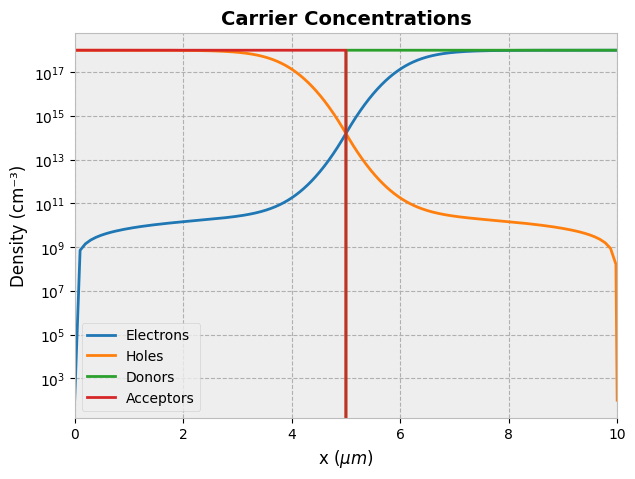

In [17]:
# ============================================================
# Carrier Density Plots
# ============================================================
fields = ("Electrons", "Holes", "Donors", "Acceptors")

plt.figure(figsize=(7,5))
for field in fields:
    y = get_node_model_values(device=device, region=region, name=field)
    plt.semilogy(np.array(x)*1e6, y, label=field)

plt.title("Carrier Concentrations", fontsize=14, weight="bold")
plt.xlabel("x ($\mu m$)")
plt.xlim(0, 10)
plt.ylabel("Density (cm⁻³)")
plt.legend()
plt.show()

The graph is particularly insightful as it clearly illustrates the behavior of charge carriers within the PN junction. Two distinct regions can be identified:

* The donor region (N-type), located before 5 µm.
* The acceptor region (P-type), located after 5 µm.

Observing the hole density (characteristic of P-type doping), we see that it is high deep within the P region. This concentration gradually decreases as we approach the junction boundary. Once across the boundary into the N region, a small number of holes can still be detected, but their presence rapidly diminishes, almost disappearing entirely, consistent with the expected behavior in a diode. The reverse is true for free electrons in the N region.

In [18]:
# Build edge-centered coordinate model
edge_average_model(
    device=device,
    region=region,
    node_model="x",
    edge_model="xmid"
)
xmid = get_edge_model_values(device=device, region=region, name="xmid")


devsim.edge_model(
    device=device,
    region=region,
    name="USRH_edge",
    equation="-0.5*ElectronCharge*( (Electrons@n0*Holes@n0 - n_i^2)/(taup*(Electrons@n0+n1) + taun*(Holes@n0+p1)) \
              + (Electrons@n1*Holes@n1 - n_i^2)/(taup*(Electrons@n1+n1) + taun*(Holes@n1+p1)) )"
);

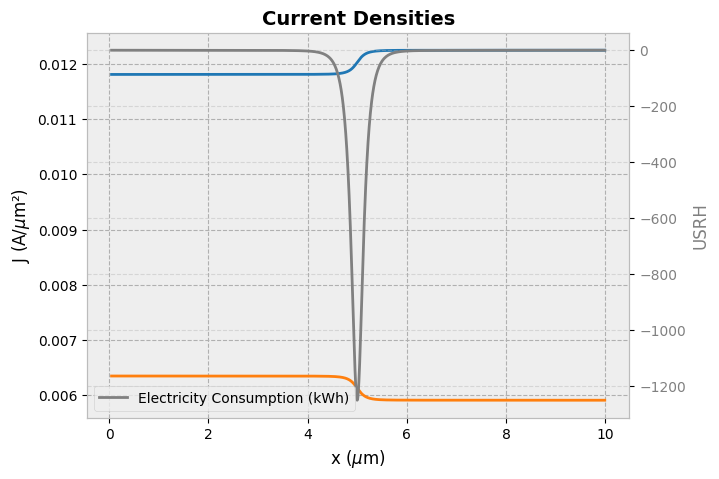

In [19]:
# ============================================================
# Current Density Plots
# ============================================================

efields = ("ElectronCurrent", "HoleCurrent")

fig, ax1 = plt.subplots(figsize=(7,5))

for field in efields:
    y = get_edge_model_values(device=device, region=region, name=field)
    ax1.plot(np.array(xmid)*1e6, y, label=field)
ax1.set_xlabel("x ($\mu$m)")
ax1.set_ylabel("J (A/$\mu$m²)")

ax2 = ax1.twinx()
ax2.plot(np.array(xmid)*1e6, get_edge_model_values(device=device, region=region, name="USRH_edge"), 'grey', label='Electricity Consumption (kWh)')
ax2.set_ylabel('USRH', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')

plt.title("Current Densities", fontsize=14, weight="bold")

plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [20]:
# Coordonnées des edges (moyenne entre n0 et n1)
devsim.edge_average_model(
    device=device,
    region=region,
    node_model="x",
    edge_model="xmid"
)
xmid = devsim.get_edge_model_values(device=device, region=region, name="xmid")

# Potentiel aux noeuds
V = devsim.get_node_model_values(device=device, region=region, name="Potential")

# Champ électrique sur les edges
E = devsim.get_edge_model_values(device=device, region=region, name="ElectricField")

Replacing Edge Model xmid in region bulk of material Si


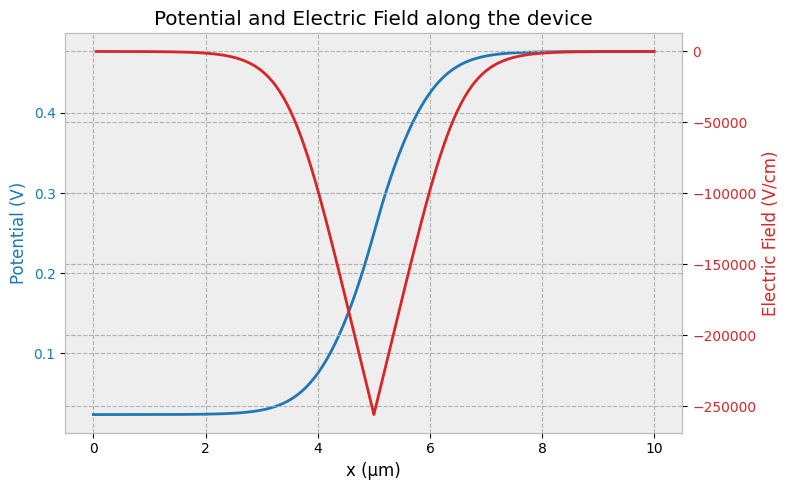

In [21]:
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('x (μm)')
ax1.set_ylabel('Potential (V)', color=color)
ax1.plot(np.array(x)*1e6, V, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Electric Field (V/cm)', color=color)
ax2.plot(np.array(xmid)*1e6, E, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Potential and Electric Field along the device")
fig.tight_layout()
plt.show()